# Problem 1:

Construct a CNN to classify the images in the MRI dataset. 

As usual, I downsample the data set and then reshape it.

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('legend', fontsize=18)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

file_dir = 'C:/Users/burch/OneDrive/Documents/MRI_Slices/'

labels = pd.read_csv(file_dir + 'labels.csv')
display(labels)
y = labels.CDR

,Unnamed: 0,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,Filename
0,0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_44.png
1,1,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_86.png
2,2,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_128.png
3,3,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,OAS1_0002_MR1_mpr_n4_anon_111_t88_gfc_44.png
4,4,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,OAS1_0002_MR1_mpr_n4_anon_111_t88_gfc_86.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,697,OAS1_0456_MR1,M,R,61,5.0,2.0,30.0,0.0,1637,0.780,1.072,NaN,OAS1_0456_MR1_mpr_n4_anon_111_t88_gfc_86.png
698,698,OAS1_0456_MR1,M,R,61,5.0,2.0,30.0,0.0,1637,0.780,1.072,NaN,OAS1_0456_MR1_mpr_n4_anon_111_t88_gfc_128.png
699,699,OAS1_0457_MR1,F,R,62,3.0,3.0,26.0,0.0,1372,0.766,1.279,NaN,OAS1_0457_MR1_mpr_n3_anon_111_t88_gfc_44.png
700,700,OAS1_0457_MR1,F,R,62,3.0,3.0,26.0,0.0,1372,0.766,1.279,NaN,OAS1_0457_MR1_mpr_n3_anon_111_t88_gfc_86.png


In [2]:
from matplotlib import pyplot as plt
import matplotlib

data = np.zeros([702, 36608])

for n, file_name in enumerate(labels.Filename):
    data[n,:] = np.mean(matplotlib.image.imread(file_dir + file_name),axis=2).reshape(-1)

    
    
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0)
print(y_train.shape, y_test.shape)

(561,) (141,)


In [3]:
#downsampling

DS = 8             # Downsample rate, must be a factor of 36608

N_train = y_train.shape[0]  # The length of the training data
y_train = np.array(y_train)

if 36608/DS % 1 > 0:
    print("Downsample rate is not a multiple of 36608")
    DS = 1
    im_size = 36608
else:
    im_size = int(36608/DS)

Xds_train = np.zeros([N_train*DS, im_size])
yds_train = np.zeros([N_train*DS])
   
for n in range(N_train):
    for i in range(DS):
        Xds_train[n*DS+i,:] = X_train[n,i::DS]
        yds_train[n*DS+i] = y_train[n]

In [4]:
#testing data
y_test = np.matrix(y_test)

Xds_test = np.zeros([141*DS, im_size])
yds_test = np.zeros([141*DS])

for n in range(140):
    for i in range(DS):
        Xds_test[n*DS+i,:] = X_test[n,i::DS]
        yds_test[n*DS+i] = y_test[0,n]

print(Xds_test.shape)
print(yds_test.shape)

(1128, 4576)
(1128,)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Reshape the data
Xds_train = X_train.reshape((-1, 4576, 1, 1)) #convolution layer will expect a 3d input
Xds_test = X_test.reshape((-1, 4576, 1, 1))
y_train = to_categorical(yds_train, num_classes=4)
y_test = to_categorical(yds_test, num_classes=4)

In [7]:
X_train_small = Xds_train[:2000]
y_train_small = y_train[:2000]
X_test_small = Xds_test[:400]
y_test_small = y_test[:400]

I once again wrestled with overfitting, but validation losses were not nearly as large and erratic as in Lab 4. After exploring a variety of hyperparameters, including activation and loss functions, batch sizes, and learning rates, I settled with this model, which achieved validation accuracy of 84%. The constant validation accuracy across epochs is puzzling. Even stranger is that it stays constant across a variety of models and hyperparameters.

Epoch 1/8
63/63 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.8695
Epoch 1: val_loss improved from inf to 0.55191, saving model to best_model.h5
63/63 [==============================] - 13s 193ms/step - loss: 0.4409 - accuracy: 0.8695 - val_loss: 0.5519 - val_accuracy: 0.8400
Epoch 2/8
63/63 [==============================] - ETA: 0s - loss: 0.4046 - accuracy: 0.8840
Epoch 2: val_loss improved from 0.55191 to 0.50298, saving model to best_model.h5
63/63 [==============================] - 13s 206ms/step - loss: 0.4046 - accuracy: 0.8840 - val_loss: 0.5030 - val_accuracy: 0.8400
Epoch 3/8
63/63 [==============================] - ETA: 0s - loss: 0.3972 - accuracy: 0.8840
Epoch 3: val_loss did not improve from 0.50298
63/63 [==============================] - 13s 213ms/step - loss: 0.3972 - accuracy: 0.8840 - val_loss: 0.5030 - val_accuracy: 0.8400
Epoch 4/8
63/63 [==============================] - ETA: 0s - loss: 0.4021 - accuracy: 0.8840
Epoch 4: val_loss did not

[0.5175953507423401, 0.8399999737739563]

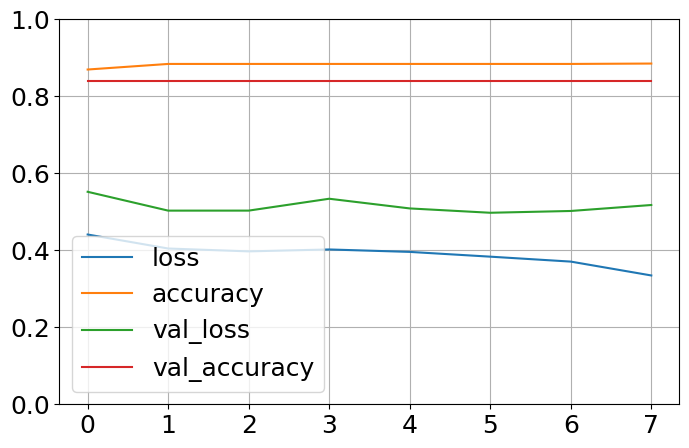

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode = 'min')

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(4576, 1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_small, y_train_small, epochs=8,
                    validation_data=(X_test_small, y_test_small), callbacks = model_checkpoint)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 1)

model.evaluate(X_test_small, y_test_small)

In [13]:
model.evaluate(X_test_small, y_test_small)

13/13 [==============================] - 0s 34ms/step - loss: 0.5176 - accuracy: 0.8400


[0.5175953507423401, 0.8399999737739563]